# Análisis exploratorio de datos SIAP y SNIIM

In [1]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

Cultivos con los que trabaja la Red BAMX.

In [3]:
# Cultivos de interés
CULTIVOS = ['Tomate rojo (jitomate)', 'Chile verde', 'Limón', 'Pepino', 'Plátano', 'Mango', 'Garbanzo', 'Brócoli', 'Cebolla', 'Sandía', 'Papaya', 'Calabacita', 'Lechuga',
            'Tomate verde', 'Espárrago', 'Frambuesa', 'Nopalitos', 'Nuez', 'Fresa', 'Toronja (pomelo)', 'Zarzamora', 'Piña', 'Coliflor', 'Frijol', 'Berenjena', 'Uva', 'Guayaba',
            'Naranja', 'Papa', 'Melón', 'Manzana', 'Pera', 'Durazno']

# Cantidad de cultivos
print(f"Cantidad de cultivos de interés: {len(CULTIVOS)}")

Cantidad de cultivos de interés: 33


## SIAP

In [43]:
# URL al archivo parquet en el repositorio
url_siap = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SIAP.parquet'
# Cargar archivo parquet como DataFrame
df_siap = pd.read_parquet(url_siap)
# Inspeccionar primeros elementos del DataFrame
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Anio,Mes,Cultivo
0,Aguascalientes,Aguascalientes,8.00,0.00,0.0,0.00,0,2023,Enero,Agave
1,Baja California Sur,La Paz,3.00,0.00,0.0,0.00,0,2023,Enero,Agave
2,Colima,Manzanillo,86.29,0.00,0.0,0.00,0,2023,Enero,Agave
3,Durango,Durango,13.00,0.00,0.0,0.00,0,2023,Enero,Agave
4,Durango,Mezquital,110.00,0.00,0.0,0.00,0,2023,Enero,Agave


In [44]:
# Cambiar nombre de columna "Anio" a "Año"
df_siap = df_siap.rename(columns={"Anio":"Año"})

#### Aplicar filtros

In [45]:
# Filtrar años del 2020 en adelante
df_siap = df_siap[df_siap['Año'] >= 2020]

In [46]:
# Filtrar cultivos de interés
df_siap = df_siap[df_siap['Cultivo'].isin(CULTIVOS)]

#### Dimensiones de los datos

In [47]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_siap.shape}\n")

Dimensión de los datos: (387646, 10)



#### Tipos de datos

In [48]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada        object
Superficie Cosechada       object
Superficie Siniestrada    float64
Produccion                 object
Rendimiento                object
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



Notamos que las variables *Superficie Sembrada*, *Superficie Cosechada*, *Producción* y *Rendimiento* son de tipo **object**, pese a que su valor es numérico

Convertimos estas variables object a flotantes

In [49]:
# Lista de variables a convertir
obj_to_float_var = ['Superficie Sembrada', 'Superficie Cosechada', 'Produccion', 'Rendimiento']

# Eliminación de ',' character y conversión a flotante
for var in obj_to_float_var:
    df_siap[var] = df_siap[var].str.replace(',','').astype('float')

# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada       float64
Superficie Cosechada      float64
Superficie Siniestrada    float64
Produccion                float64
Rendimiento               float64
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



### Valores faltantes

In [50]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                   0
Municipio                 0
Superficie Sembrada       0
Superficie Cosechada      0
Superficie Siniestrada    0
Produccion                0
Rendimiento               0
Año                       0
Mes                       0
Cultivo                   0
dtype: int64


#### Definición de constantes

In [51]:
# Orden cronológico de los meses
MESES_CRONOLOGICO = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Lista de colores para cada año
COLORES = ['#ffd343', '#42ff75', '#426eff', '#ff42cc']

# Lista de cultivos únicos
CULTIVOS_UNICOS = list(df_siap['Cultivo'].unique())

# Lista de años únicos
AÑOS_UNICOS = list(df_siap['Año'].unique())

# Lista de estado únicos
ESTADOS_UNICOS = list(df_siap['Entidad'].unique())

# Lista de estado únicos
MUNICIPIOS_UNICOS = list(df_siap['Municipio'].unique())

#### Obtención de valores mensuales

Por defecto, el SIAP arroja los datos numéricos (Superficie Sembrada, Superficie Cosechada, Superficie Siniestrada, Produccion, Rendimiento) de manera acumulativa. Esto implica que, para un año dado, los valores de, por ejemplo Febrero, son los valores de Enero más los de Febrero; los valores de Marzo son los valores de Enero, más los de Febrero, más los de Marzo; y así sucesivamente. Nosotros estamos interesados en analizar los valores de manera mensual y por ende, es necesario que a los valores de cada mes le restemos los valores de los meses previos. Aún así, decidimos mantener los datos acumulativos originales como referencia para corroborar que los valores mensuales se obtuvieron correctamente, y en caso de que sean de utilidad más adelante en el EDA.

In [52]:
# Hacemos que la columna Mes sea una categoría con un orden cronológico
df_siap['Mes'] = pd.Categorical(df_siap['Mes'], categories=MESES_CRONOLOGICO, ordered=True)

# Ordenar por 'Año' y 'Mes'
df_siap = df_siap.sort_values(by=['Año', 'Mes'])

# Operación de diferencia por grupo
cols_to_diff = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion"]

df_siap_diff = df_siap.groupby(['Entidad', 'Municipio', 'Cultivo'])[cols_to_diff].diff().fillna(df_siap[cols_to_diff])

# Reemplazar NaN en Enero con los valores acumulados originales
mask_enero = df_siap['Mes'] == 'Enero'
df_siap_diff.loc[mask_enero, :] = df_siap.loc[mask_enero, cols_to_diff].values

# Agregar las columnas de diferencia al DataFrame original
df_siap = pd.concat([df_siap, df_siap_diff], axis=1)

# Verificar los resultados
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
565841,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
565842,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
565843,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
565844,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
565845,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


In [57]:
# Cambiar el nombre de las columnas originales
df_siap.columns.values[2] = "Superficie Sembrada Acumulada"
df_siap.columns.values[3] = "Superficie Cosechada Acumulada"
df_siap.columns.values[4] = "Superficie Siniestrada Acumulada"
df_siap.columns.values[5] = "Produccion Acumulada"

# Verificar los resultados
df_siap.head()

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
565841,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
565842,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
565843,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
565844,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
565845,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


Comprobamos que no hayan valores faltantes

In [54]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                             0
Municipio                           0
Superficie Sembrada Acumulada       0
Superficie Cosechada Acumulada      0
Superficie Siniestrada Acumulada    0
Produccion Acumulada                0
Rendimiento                         0
Año                                 0
Mes                                 0
Cultivo                             0
Superficie Sembrada                 0
Superficie Cosechada                0
Superficie Siniestrada              0
Produccion                          0
dtype: int64


#### Definimos constantes

In [58]:
# Lista de variables numéricas en el DataFrame
VARIABLES_NUMERICAS_SIAP = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion", "Rendimiento",
                             "Superficie Sembrada Acumulada", "Superficie Cosechada Acumulada", "Superficie Siniestrada Acumulada", "Produccion Acumulada"]

In [59]:
# # Ordenamos el DataFrame con base en el orden cronológico de los meses
# df_siap['Mes'] = pd.Categorical(df_siap['Mes'], categories=MESES_CRONOLOGICO, ordered=True)  # Convertir 'Mes' en una categoría con el orden cronológico
# df_siap = df_siap.sort_values(by='Mes')  # Ordenar DataFrame con base en la columna 'Mes'

# # Crear DataFrame en el que almacenaremos la producción mensual no acumulativa
# df_siap_diff = pd.DataFrame(columns=df_siap.columns)

# # Iteramos por año
# for año in AÑOS_UNICOS[::-1]:

#    # Iteramos por estado
#    for estado in ESTADOS_UNICOS:
       
#        # Iteramos por cultivo
#        for cultivo in CULTIVOS_UNICOS:

#            # Datos del estado, año y cultivo en turno
#            df_ent_year_cult = df_siap_diff[(df_siap['Entidad'] == estado) & (df_siap['Año'] == año) & (df_siap['Cultivo'] == cultivo)]

#            # Resta de valores de meses previos
#            df_ent_year_cult['Superficie Sembrada'] = df_ent_year_cult['Superficie Sembrada Acumulada'].diff().fillna(df_ent_year_cult['Superficie Sembrada Acumulada'])
#            df_ent_year_cult['Superficie Cosechada'] = df_ent_year_cult['Superficie Cosechada Acumulada'].diff().fillna(df_ent_year_cult['Superficie Cosechada Acumulada'])
#            df_ent_year_cult['Superficie Siniestrada'] = df_ent_year_cult['Superficie Siniestrada Acumulada'].diff().fillna(df_ent_year_cult['Superficie Siniestrada Acumulada'])
#            df_ent_year_cult['Produccion'] = df_ent_year_cult['Produccion Acumulada'].diff().fillna(df_ent_year_cult['Produccion Acumulada'])
#            #df_ent_year_cult['Rendimiento'] = df_ent_year_cult['Rendimiento'].diff().fillna(df_ent_year_cult['Rendimiento'])

#            # Alamacenar resultados en el nuevo DataFrame
#            df_siap_diff = pd.concat([df_siap_diff, df_ent_year_cult], axis=0)

#            df_siap_diff = df_siap_diff.reset_index(drop=True)

# # Inspeccionamos el nuevo DataFrame
# df_siap_diff

### Detección de outliers

In [60]:
# Descripción de variables numéricas
df_siap.drop(columns='Año', axis=1).describe().round(2)

,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
count,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00
mean,293.41,163.20,2.55,2100.48,12.66,22.71,18.42,0.55,291.64
std,1785.48,1137.74,175.58,12469.44,27.83,714.08,762.76,94.87,3039.27
min,0.00,0.00,0.00,0.00,0.00,-84685.00,-119950.00,-11653.00,-243853.50
25%,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.00,5.50,0.00,37.00,3.20,0.00,0.00,0.00,0.00
75%,98.00,40.00,0.00,418.00,15.53,0.00,0.00,0.00,16.37
max,120900.00,119950.00,28372.00,722238.00,696.43,93500.00,84040.00,28372.00,300352.00


Notamos que los valores mínimos de las nuevas columnas con datos mensuales son negativos, lo cual no tiene sentido. Contamos la cantidad de valores negativos en estas variables, con el objetivo de identificar si cometimos un error en el cálculo de los valores mensuales, o si simplemente se trata de que hubo errores a la hora de registrar los datos. 

In [61]:
# Evaluar cantidad y porcentaje respectivo de valores negativos por columnas 
print(f"Cantidad de valores negativos en Superficie Sembrada: {sum(df_siap['Superficie Sembrada'] < 0)} ({round(sum(df_siap['Superficie Sembrada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Superficie Cosechada: {sum(df_siap['Superficie Cosechada'] < 0)} ({round(sum(df_siap['Superficie Cosechada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Superficie Siniestrada: {sum(df_siap['Superficie Siniestrada'] < 0)} ({round(sum(df_siap['Superficie Siniestrada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Produccion: {sum(df_siap['Produccion'] < 0)} ({round(sum(df_siap['Produccion'] < 0)/len(df_siap) * 100,2)}%)")

Cantidad de valores negativos en Superficie Sembrada: 6907 (1.78%)

Cantidad de valores negativos en Superficie Cosechada: 9522 (2.46%)

Cantidad de valores negativos en Superficie Siniestrada: 438 (0.11%)

Cantidad de valores negativos en Produccion: 9606 (2.48%)


Debido a la pequeña cantidad de valores faltantes, lo más factible es que se hayan cometido errores a la hora de registrar los datos. Por lo tanto, podemos simplemente eliminar estos valores negativos y continuar con el análisis.

In [62]:
# Descartar filas con valores valores negativos
df_siap  = df_siap[(df_siap['Superficie Sembrada'] >= 0) & (df_siap['Superficie Cosechada'] >= 0) & (df_siap['Superficie Siniestrada'] >= 0) & (df_siap['Produccion'] >= 0) ]

# Repetir describe
df_siap.drop(columns='Año', axis=1).describe().round(2)

,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
count,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00
mean,297.54,167.24,2.62,2151.31,12.97,31.80,29.81,0.93,348.98
std,1791.53,1151.34,177.81,12618.12,28.09,558.01,515.38,89.39,2736.83
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.50,6.00,0.00,42.25,3.80,0.00,0.00,0.00,0.00
75%,100.00,41.00,0.00,445.00,15.95,0.00,0.00,0.00,18.73
max,120900.00,119950.00,28372.00,722238.00,696.43,93500.00,84040.00,28372.00,300352.00


#### Dispersión de los datos

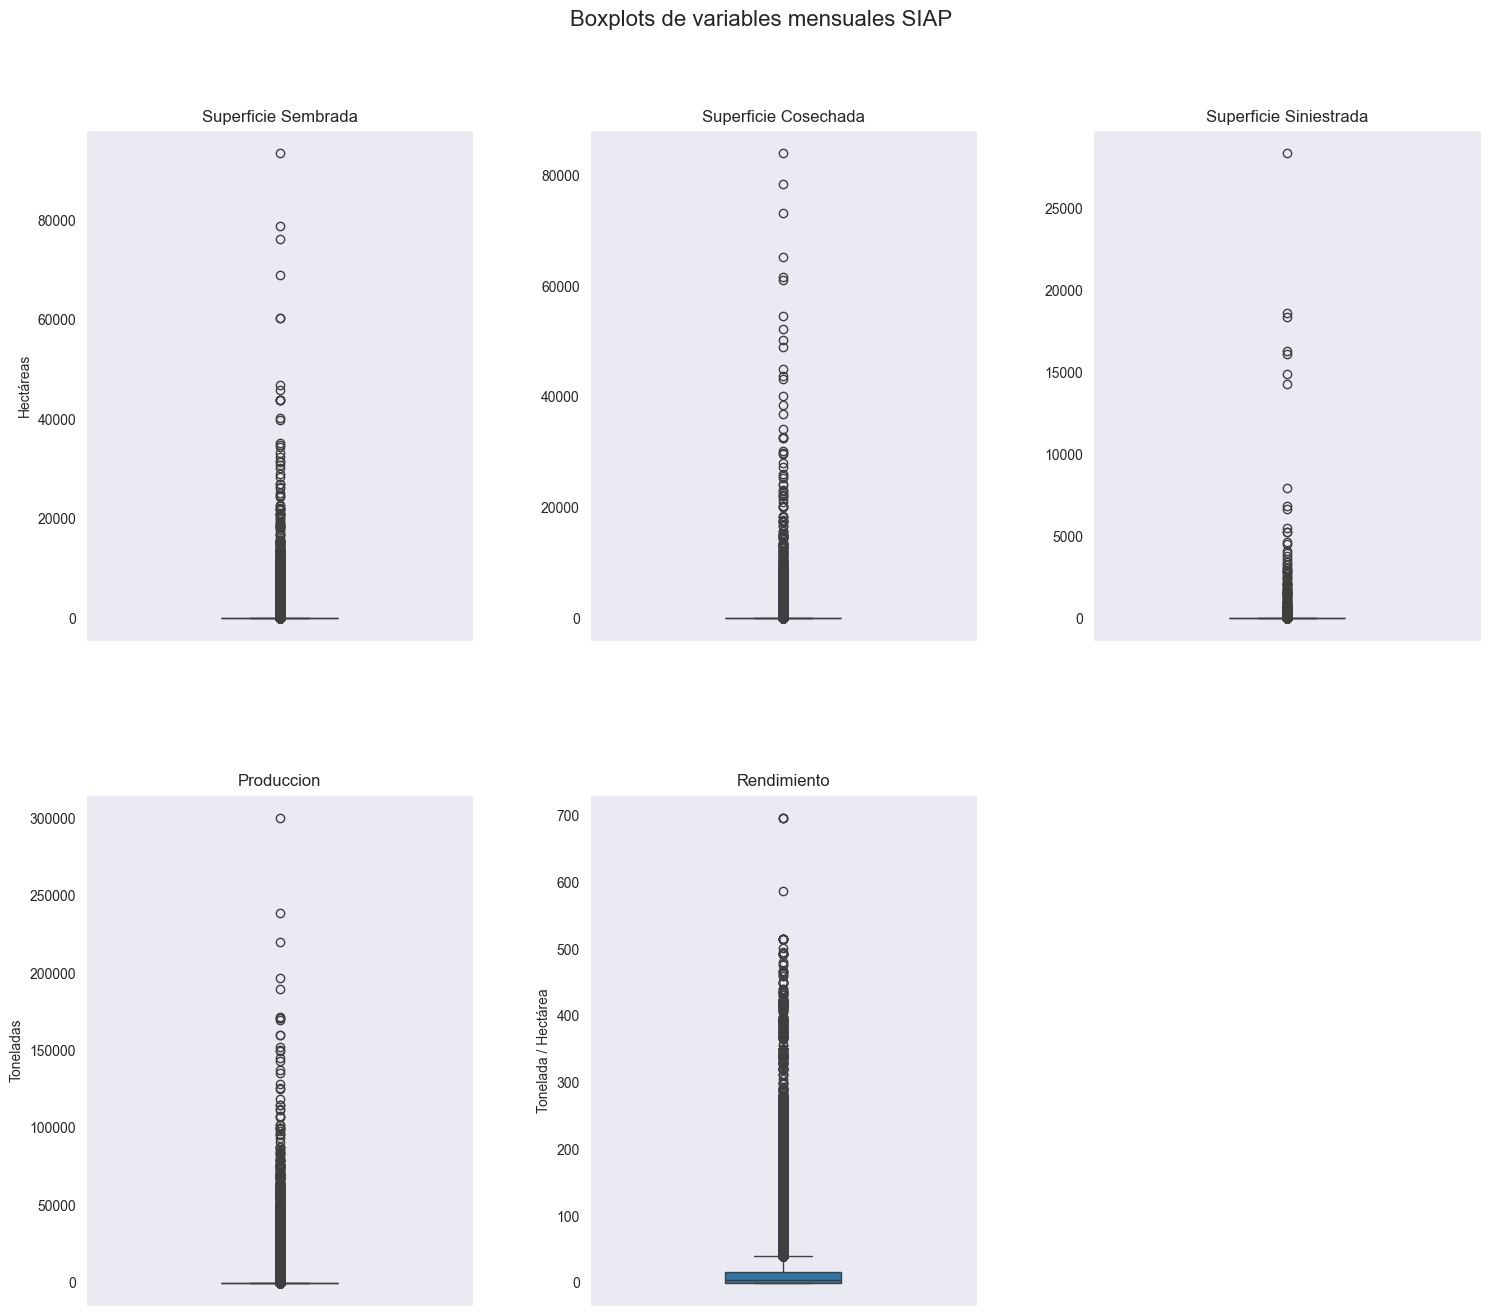

In [63]:
# Fijamos estilo
sns.set_style("dark")

# Configurar la figura y los subplots
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    sns.boxplot(data=df_siap, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables mensuales SIAP', fontsize=16)

axes[0].set_ylabel('Hectáreas')
axes[3].set_ylabel('Toneladas')
axes[4].set_ylabel('Tonelada / Hectárea')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

In [72]:
# # Configurar la figura y los subplots
# num_rows = 2
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# # Ajustar el espacio entre subplots
# fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# # Asegurarse de que 'axes' sea una matriz 2D
# axes = axes.reshape(-1)

# # Iterar a través de las columnas numéricas y crear histogramas de densidad kde
# for i, variable in enumerate(VARIABLES_NUMERICAS_MENSUALES):
#     sns.histplot(data=df_siap, x=variable, kde=True, ax=axes[i])
#     axes[i].set_title(f'{variable}')
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')

# # Eliminar la subgráfica vacía correspondiente a la variable FastingBS
# fig.delaxes(axes[-1])

# # Agregar un título general a la figura
# fig.suptitle('Distribuciones de densidad de variables mensuales SIAP', fontsize=16)

# axes[0].set_ylabel('Hectáreas')
# axes[3].set_ylabel('Toneladas')
# axes[4].set_ylabel('Tonelada / Hectárea')

# # Ajustar el espaciado entre subplots
# #plt.tight_layout()

# # Mostrar la figura
# plt.show()

#### Método Local Factor Outlier

In [64]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_siap.drop(columns=['Entidad', 'Municipio', 'Año', 'Mes', 'Cultivo'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_siap) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 29552
Porcentaje con respecto al total de datos: 7.82%


Inspeccionamos algunos datos outlier según Local Factor Outlier

In [65]:
# Obtener datos outlier según LOF
outliers_LOF = df_siap[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=10)

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
214542,Oaxaca,Santiago Comaltepec,4.46,0.0,0.0,0.00,0.00,2022,Mayo,Manzana,0.00,0.0,0.0,0.00
421637,Oaxaca,El Espinal,3.25,2.0,0.0,14.60,7.30,2021,Mayo,Mango,0.00,0.0,0.0,1.04
50809,Chihuahua,Hidalgo del Parral,195.19,0.0,0.0,0.00,0.00,2023,Abril,Nuez,0.00,0.0,0.0,0.00
311969,Oaxaca,Teotitlán de Flores Magón,7.00,7.0,0.0,200.90,28.70,2022,Octubre,Papaya,0.00,0.0,0.0,0.00
749801,Guerrero,Azoyú,19.00,18.0,0.0,163.74,9.10,2020,Diciembre,Limón,0.00,0.0,0.0,4.72
391630,Jalisco,Tomatlán,10.50,0.0,0.0,0.00,0.00,2021,Marzo,Melón,0.27,0.0,0.0,0.00
142758,San Luis Potosí,Ebano,118.00,80.0,0.0,1466.50,18.33,2023,Septiembre,Naranja,0.00,0.0,0.0,0.00
117678,Veracruz,Fortín,8.64,0.0,0.0,0.00,0.00,2023,Agosto,Frijol,0.00,0.0,0.0,0.00
538339,Oaxaca,Santiago Xiacuí,10.00,10.0,0.0,6.90,0.69,2021,Noviembre,Nuez,0.00,0.0,0.0,2.80
251586,Michoacán,Villamar,2.00,2.0,0.0,14.88,7.44,2022,Julio,Naranja,0.00,0.0,0.0,0.00


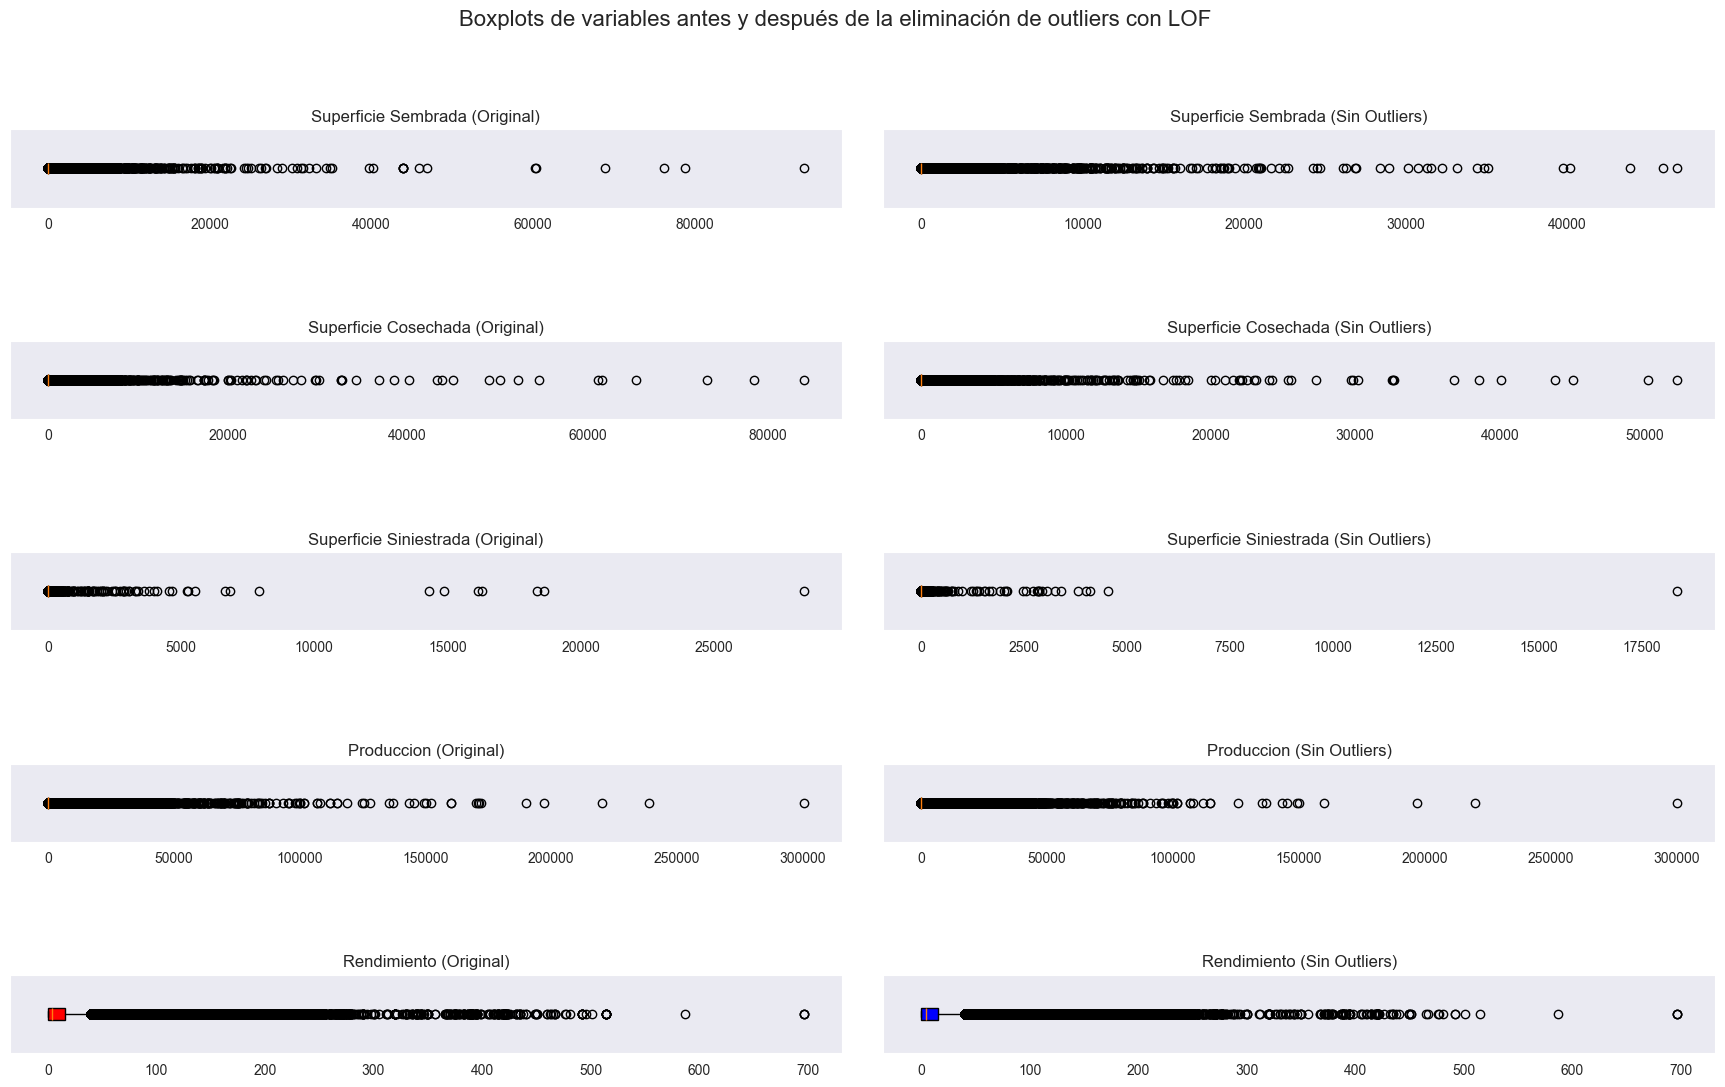

In [66]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_siap[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_siap[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

#### Método Isolation Forest

In [67]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas 
X = df_siap.drop(columns=['Entidad', 'Municipio', 'Año', 'Mes', 'Cultivo'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_siap) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")


Cantidad de outliers: 20338
Porcentaje con respecto al total de datos: 5.38%


Inspeccionamos algunos datos outlier según Isolation Forest

In [68]:
# Obtener datos outlier según IF
outliers_IF = df_siap[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=10)

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
670874,Zacatecas,Fresnillo,14243.00,4872.87,160.5,118984.00,24.42,2020,Agosto,Chile verde,11.0,4872.87,160.5,118984.00
335546,Zacatecas,Fresnillo,1130.00,1130.00,0.0,50285.00,44.50,2022,Noviembre,Tomate verde,0.0,0.00,0.0,0.00
717785,Colima,Manzanillo,1705.04,1705.04,0.0,56679.12,33.24,2020,Octubre,Plátano,0.0,0.00,0.0,3098.92
233960,Sinaloa,Culiacán,1315.93,1315.93,0.0,117402.67,89.22,2022,Junio,Pepino,0.0,0.00,0.0,0.00
226980,Nayarit,Rosamorada,6154.00,6154.00,0.0,5793.20,0.94,2022,Junio,Frijol,0.0,10.00,0.0,0.00
625850,Tamaulipas,Llera,4465.87,2541.60,0.0,52083.90,20.49,2020,Mayo,Naranja,0.0,1581.00,0.0,32081.70
698444,Veracruz,Jalacingo,2103.00,798.59,0.0,19016.16,23.81,2020,Septiembre,Papa,793.0,685.09,0.0,15241.41
61795,Sinaloa,Sinaloa,8898.00,8883.00,15.0,16158.92,1.82,2023,Mayo,Frijol,0.0,2167.00,0.0,3872.21
200326,Colima,Manzanillo,1757.74,1757.74,0.0,16775.90,9.54,2022,Abril,Plátano,0.0,0.00,0.0,3392.70
335154,Jalisco,Jesús María,900.00,690.00,0.0,16641.32,24.12,2022,Noviembre,Tomate verde,0.0,220.00,0.0,5329.09


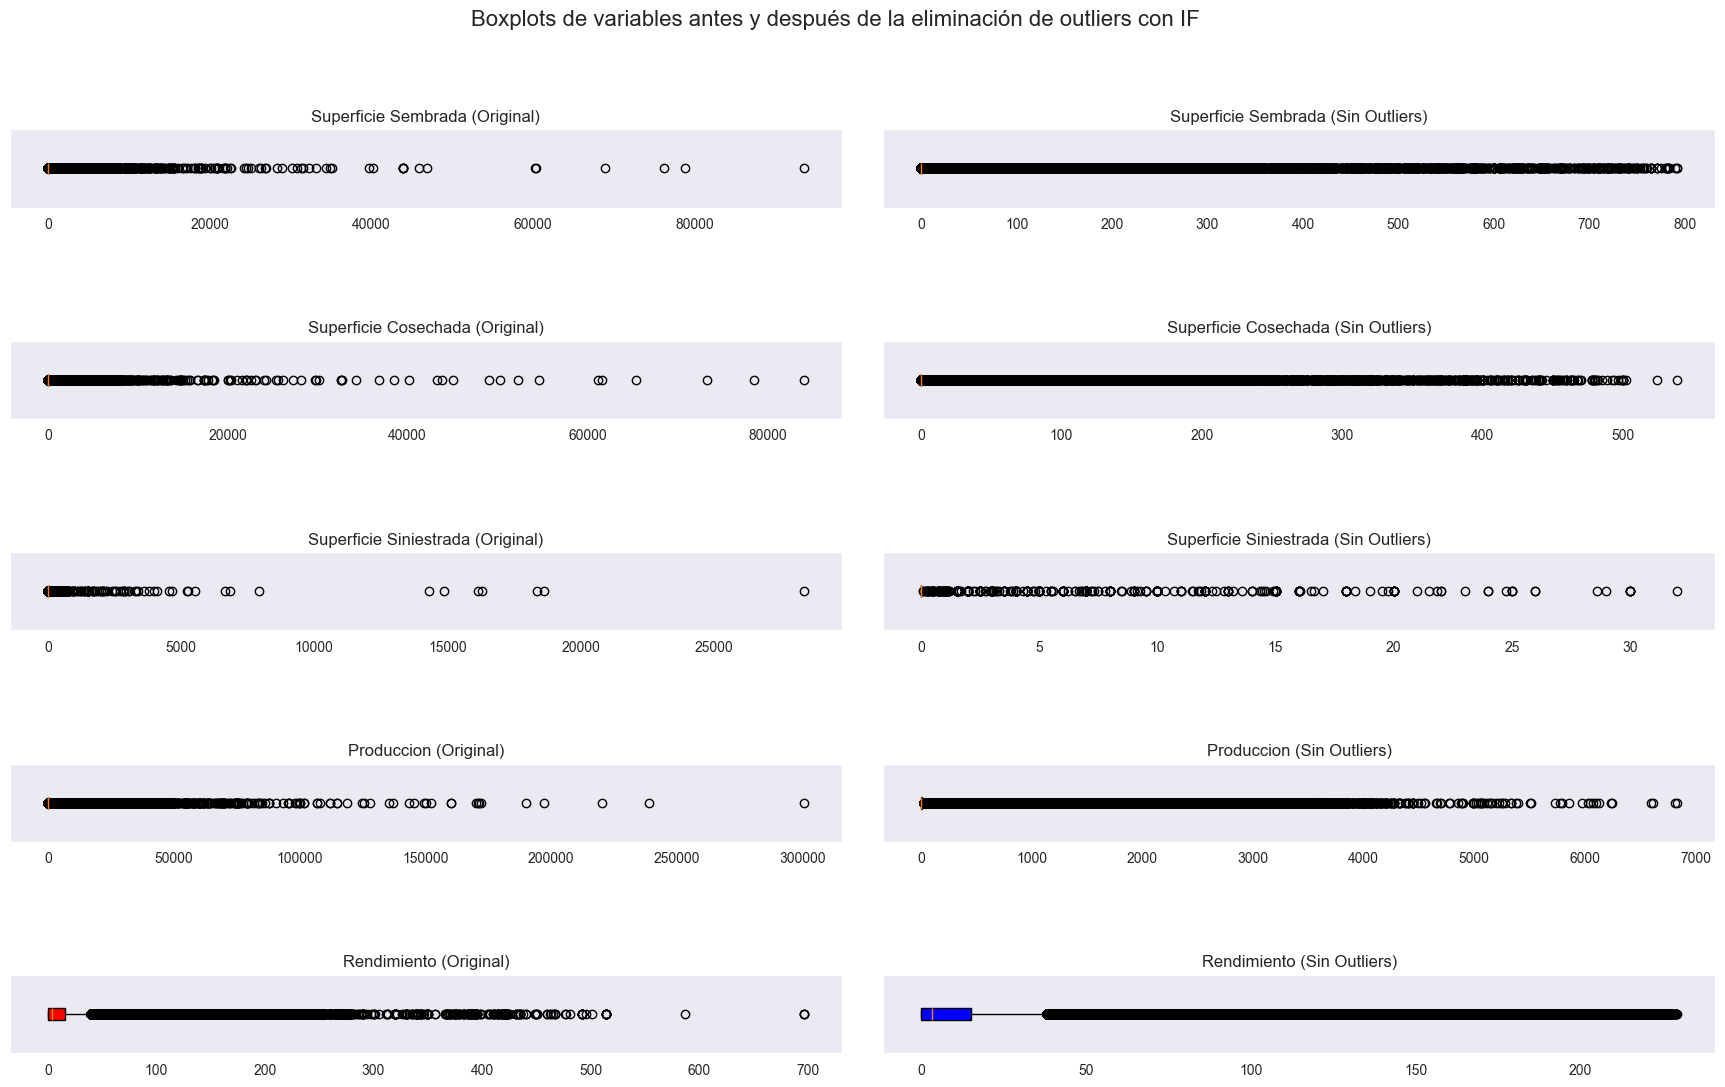

In [69]:
# Eliminar outliers del DataFrame
df_clean_IF = df_siap[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_siap[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los outliers putativos no nos permite identificarlos como verdaderamente valores atípicos. Es esperable que en ciertas épocas la producción de algunos cultivos incremente de manera significativa. Por esto y otros factores, decidimos conservar los outliers putativos y continuar el EDA con el DataFrame completo.  

## SNIIM

In [70]:
# Path al archivo parquet
url_sniim = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SNIIM.parquet'
# Cargar archivo parquet como DataFrame
df_sniim = pd.read_parquet(url_sniim)
# Inspeccionar primeros elementos del DataFrame
df_sniim.sample(n=5)

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo
847007,22/01/2019,Caja de 9 kg.,Distrito Federal,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",55.56,61.11,55.56,nan,uva globo_primera
555473,20/04/2018,Caja de 18 kg.,Chihuahua,Aguascalientes: Centro Comercial Agropecuario ...,25.28,25.83,25.56,A GRANEL,manzana red delicious_primera
780073,24/09/2020,Kilogramo,Coahuila,"Coahuila: Central de Abasto de La Laguna, Torreón",6.00,7.00,6.50,nan,sandía sangría_primera
495296,21/02/2022,Kilogramo,Veracruz,DF: Central de Abasto de Iztapalapa DF,47.00,63.00,49.00,nan,limón s/semilla_primera
725709,15/05/2018,Caja de 18 kg.,Chiapas,"Baja California : Central de Abasto INDIA, Tij...",12.22,12.22,12.22,nan,plátano chiapas_primera


Los valores de precio están estandarizados a KG y por ende las columnas "Presentacion" y "Observacion" son remanentes que podemos eliminar

In [71]:
# Descartamos columnas Presentacion y Observacion
df_sniim = df_sniim.drop(['Presentacion', 'Observacion'], axis=1)

#### Dimensiones de los datos

In [72]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (900763, 7)


#### Tipos de datos

In [73]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha                object
Origen               object
Destino              object
Precio Minimo       float64
Precio Maximo       float64
Precio Frecuente    float64
Cultivo              object
dtype: object



Notamos que la variable *Fecha* es de tipo **object**, por lo que la convertimos a **datetime** para facilitar futuros análisis

In [74]:
# Efectuar conversión especificando el formato específico de la fecha
df_sniim['Fecha'] = pd.to_datetime(df_sniim['Fecha'], format="%d/%m/%Y")
# Inspeccionar nuevamente el tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha               datetime64[ns]
Origen                      object
Destino                     object
Precio Minimo              float64
Precio Maximo              float64
Precio Frecuente           float64
Cultivo                     object
dtype: object



#### Aplicar filtros

In [75]:
#Filtramos nuestro DataFrame solo para los años 2020 - 2023 
df_sniim = df_sniim[df_sniim['Fecha'].dt.year >= 2020]

Nota: a causa de la diferencia en el nombre de los cultivos entre los DataFrames, el filtrado con los cultivos de interés de la Red BAMX se dejará para más adelante

#### Valores faltantes

In [76]:
# Valores faltantes
print(f"Valores faltantes:\n {df_sniim.isna().sum()}")

Valores faltantes:
 Fecha               0
Origen              0
Destino             0
Precio Minimo       0
Precio Maximo       0
Precio Frecuente    0
Cultivo             0
dtype: int64


### Homologar DataFrames

Antes de poder efectuar análisis conjuntos con estos DataFrames es necesario realizar ciertos pasos para homologar los datos:

- Ajustar los nombres de los estados de Origen en los datos del SNIIM
- Ajustar los nombres de los cultivos del SNIIM
- Promediar los precios del SNIIM de manera mensual

In [77]:
# # Eliminar columna 'Destino'
# df_sniim_dest = df_sniim.drop('Destino', axis=1)

# # Eliminar columna 'Municipio'
# df_siap_mun = df_siap.drop('Municipio', axis=1)

# # En ambos casos es necesario sumar los valores numericos que coincidad en Estado, Año, Mes y Cultivo 
# df_sniim_dest = df_sniim_dest.groupby(['Fecha', 'Origen', 'Cultivo'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].sum().reset_index()
# df_siap_mun = df_siap_mun.groupby(['Año', 'Mes', 'Entidad', 'Cultivo'])[['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada', 'Produccion', 'Rendimiento']].sum().reset_index()

#### Ajustar los nombres de los estados de Origen

In [78]:
# Evaluamos qué nombres de estado en el sniim no están en el siap
print('Estados del SNIIM no presentes en el SIAP:\n')
for estado_sniim in df_sniim['Origen'].unique():
    if estado_sniim not in df_siap['Entidad'].unique():
        print(estado_sniim)

Estados del SNIIM no presentes en el SIAP:

Distrito Federal
Importación
Nacional


Reemplazamos "Distrito Federal" por "Ciudad de México" tal como viene en el SIAP. Descartamos las filas con datos "Importación", "Nacional" y "Sin Especificar"

In [79]:
# Crear copia del dataframe
df_sniim_orig = df_sniim.copy()

# Reemplazamos Distrito Federal por Ciudad de México
condicion = df_sniim_orig['Origen'] == "Distrito Federal"
df_sniim_orig.loc[condicion, 'Origen'] = 'Ciudad de México' 

# Descartamos la filas cuyo valor en la columna "Origen" es Importación o Nacional
df_sniim_orig = df_sniim_orig[(df_sniim_orig['Origen'] != 'Importación') | (df_sniim_orig['Origen'] != 'Nacional') | (df_sniim_orig['Origen'] != 'Sin Especificar')]

#### Ajustar los nombres de los cultivos del SNIIM

Para esto debemos tomar como referencia la lista de cultivos ofrecida por el experto de la red BAMX.

In [80]:
# Inspeccionamos nuevamente algunos elementos de la lista de cultivos
CULTIVOS[:10]

['Tomate rojo (jitomate)',
 'Chile verde',
 'Limón',
 'Pepino',
 'Plátano',
 'Mango',
 'Garbanzo',
 'Brócoli',
 'Cebolla',
 'Sandía']

Ahora inspeccionamos los cultivos de los datos del SNIIM.

In [81]:
# Inspeccionar algunos nombres de cultivos
df_sniim['Cultivo'].sample(n=10)

405397          guayaba_primera
416629          jamaica_primera
548965      mango tommy_primera
601036    naranja agria_primera
172062    chile chilaca_primera
145158      chile ancho_primera
283131     ciruela pasa_primera
347334            ejote_primera
409243       haba verde_primera
868677     uva thompson_primera
Name: Cultivo, dtype: object

El formato consiste en el nombre de los cultivos seguido por una descripción de la variedad.
Debido a que en el SIAP no se maneja variedad, para poder homologar los datos nos quedamos solamente con el nombre de los cultivos. No obstante, esto aplica solo para los cultivos cuyo nombre consiste en una sola palabra. Para los nombres con más palabras utilizamos un abordaje manual. 

In [82]:
# Nombres de cultivo con más de una palabra
[cultivo for cultivo in CULTIVOS if len(cultivo.split(' ')) > 1]

['Tomate rojo (jitomate)', 'Chile verde', 'Tomate verde', 'Toronja (pomelo)']

In [83]:
# Crear copia del DataFrame
df_sniim_orig_cult = df_sniim_orig.copy()

# Creamos una nueva columna en nuestro DataFrame para almacenar los nuevos nombres de los cultivos
df_sniim_orig_cult['Cultivo SIAP'] = df_sniim_orig_cult['Cultivo']

# Tomate rojo (jitomate): reemplazamos los cultivos "tomate bola_primera" y "tomate saladette_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['tomate bola_primera', 'tomate saladette_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate rojo (jitomate)'

# Tomate verde: reemplazamos el cultivo "tomate verde_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'] == 'tomate verde_primera'

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate verde'

# Toronja (pomelo): reemplazamos el cultivo "toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera" y "toronja rosada_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(["toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera", "toronja rosada_primera"])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Toronja (pomelo)'

# Chile verde: reemplazamos el cultivo 'chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera', 'chile jalapeño_primera' y 'chile habanero_primera'

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera',
                                       'chile jalapeño_primera', 'chile habanero_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Chile verde'

# Nopalitos: en el SNIIM vienen solamente como Nopal

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['nopal grande_primera', 'nopal_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Nopalitos'

Podemos automatizar el ajuste de los nombres de cultivo con una sola palabra utilizando expresiones regulares

In [84]:
# Condición para ignorar los cultivos que ya modificamos
condicion = ~df_sniim_orig_cult['Cultivo SIAP'].isin(['Tomate rojo (jitomate)', 'Tomate verde', 'Toronja (pomelo)', 'Nopalitos', 'Chile verde'])

# Expresión regular para capturar la primera palabra
pattern = r'^([^\W_]+)'

# Aplicar la expresión regular para mantener solo la primera palabra
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_orig_cult[condicion]['Cultivo SIAP'].str.extract(pattern).values

# Reemplazar la primera letra por mayúscula
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'].str.title()

# Inspeccionar nuevamente algunos nombres de cultivos
df_sniim_orig_cult['Cultivo SIAP'].sample(n=10)

135834                   Chayote
627595                 Nopalitos
766537                    Rábano
63444                  Cacahuate
412283                      Haba
649540                   Orégano
803751    Tomate rojo (jitomate)
849857                       Uva
814671          Toronja (pomelo)
137777                   Chayote
Name: Cultivo SIAP, dtype: object

Utilizamos nuevamente la lista de cultivos para filtrar el DataFrame

In [85]:
# Filtramos el DataFrame para quedarnos solo con los cultivos de interés
df_sniim_orig_cult = df_sniim_orig_cult[df_sniim_orig_cult['Cultivo SIAP'].isin(CULTIVOS)]

# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim_orig_cult.shape}")

# Inspeccionamos el DataFrame
df_sniim_orig_cult.sample(n=5)

Dimensión de los datos: (334540, 8)


,Fecha,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Cultivo,Cultivo SIAP
403390,2020-08-24,Jalisco,"Baja California : Central de Abasto INDIA, Tij...",27.50,27.5,27.50,guayaba_primera,Guayaba
205055,2023-05-09,Nayarit,Nayarit: Mercado de abasto 'Adolfo López Mateo...,111.00,113.0,112.00,chile habanero_primera,Chile verde
656467,2020-02-13,Michoacán,Aguascalientes: Centro Comercial Agropecuario ...,10.00,13.0,12.00,papaya maradol_primera,Papaya
535431,2021-11-19,Chiapas,Durango: Centro de Distribución y Abasto de Gó...,14.00,18.9,16.00,mango manililla_primera,Mango
517369,2022-07-27,Chiapas,Aguascalientes: Centro Comercial Agropecuario ...,14.33,15.0,14.67,mango ataulfo_primera,Mango


Debido a la manipulación que realizamos con los cultivos del SNIIM para homologarlos con los del SIAP, es posible que un mismo cultivo presente distintos precios para una misma fecha y mercado. Para abordar esto, identificamos los casos en los que estos sucede y promediamos los precios.

In [86]:
# Agrupar por Fecha, Origen y Destino
df_sniim_orig_cult = df_sniim_orig_cult.groupby(["Fecha", "Origen", "Destino", "Cultivo SIAP"])[["Precio Minimo", "Precio Maximo", "Precio Frecuente"]].mean().reset_index()

# Inspeccionar resultado
df_sniim_orig_cult.sample(n=5)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
1605,2020-01-08,Campeche,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",Calabacita,15.000,15.000,15.000
248937,2023-05-19,Colima,Aguascalientes: Centro Comercial Agropecuario ...,Limón,21.915,23.105,22.505
61139,2020-11-24,Ciudad de México,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",Pera,37.500,40.000,37.500
77419,2021-02-24,Importación,Jalisco: Mercado Felipe Ángeles de Guadalajara,Manzana,33.820,33.820,33.820
35418,2020-05-26,Guerrero,DF: Central de Abasto de Iztapalapa DF,Mango,10.890,13.215,12.500


#### Definimos constantes

In [87]:
VARIABLES_NUMERICAS_SNIIM = ["Precio Minimo", "Precio Maximo", "Precio Frecuente"]

##### Promedio mensual de precios SNIIM

In [88]:
# Crear copia del DataFrame
df_sniim_orig_cult_mes = df_sniim_orig_cult.copy()

# Desglosar la columna Fecha en dos columnas adicionales para el año y el mes
df_sniim_orig_cult_mes['Año'] = df_sniim_orig_cult_mes['Fecha'].dt.year
df_sniim_orig_cult_mes['Mes'] = df_sniim_orig_cult_mes['Fecha'].dt.month

# Agrupar por Año, Mes, Origen, Destino y Cultivo SIAP, y calcular el promedio de los precios
df_sniim_dest_orig_cult_mens = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Origen', 'Cultivo SIAP'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].mean().round(2).reset_index()

# Diccionario para mapear números de mes a nombres de mes
meses_dict = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

# Aplicar el mapeo a la columna 'Mes'
df_sniim_orig_cult_mes['Mes'] = df_sniim_orig_cult_mes['Mes'].map(meses_dict)

# DataFrame resultante
df_sniim_orig_cult_mes

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente,Año,Mes
0,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Brócoli,12.00,14.00,13.00,2020,Enero
1,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Calabacita,11.33,12.67,12.00,2020,Enero
2,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Coliflor,13.00,15.00,14.00,2020,Enero
3,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Guayaba,8.75,9.58,9.17,2020,Enero
4,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Lechuga,6.00,8.00,7.00,2020,Enero
...,...,...,...,...,...,...,...,...,...
286031,2023-10-25,Veracruz,Veracruz: Mercado Malibrán,Plátano,13.00,19.50,15.00,2023,Octubre
286032,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Naranja,21.00,21.00,21.00,2023,Octubre
286033,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Uva,120.00,120.00,120.00,2023,Octubre
286034,2023-10-25,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Tomate verde,6.00,8.00,7.00,2023,Octubre


El DataFrame con los datos del SNIIM promediados mensualmente será utilizado específicamente para los análisis conjuntos con los datos del SIAP. Para análsis individuales, se utilizarán los datos del SNIIM que mantienen los precios diarios.

### Detección de outliers

Primero inspeccionamos las variables numéricas de nuestros datos para una identificación burda de posibles outliers.

In [89]:
# Descripción de variables numéricas
df_sniim_orig_cult.drop(columns='Fecha', axis=1).describe().round(2)

,Precio Minimo,Precio Maximo,Precio Frecuente
count,286036.00,286036.00,286036.00
mean,27.53,30.89,29.35
std,33.15,35.08,34.26
min,0.25,0.35,0.30
25%,12.00,13.50,12.63
50%,16.67,20.00,18.00
75%,30.00,34.44,32.00
max,390.00,390.00,390.00


No se observan anormalidades como valores negativos o precios muy extremos.


#### Dispersión de los datos

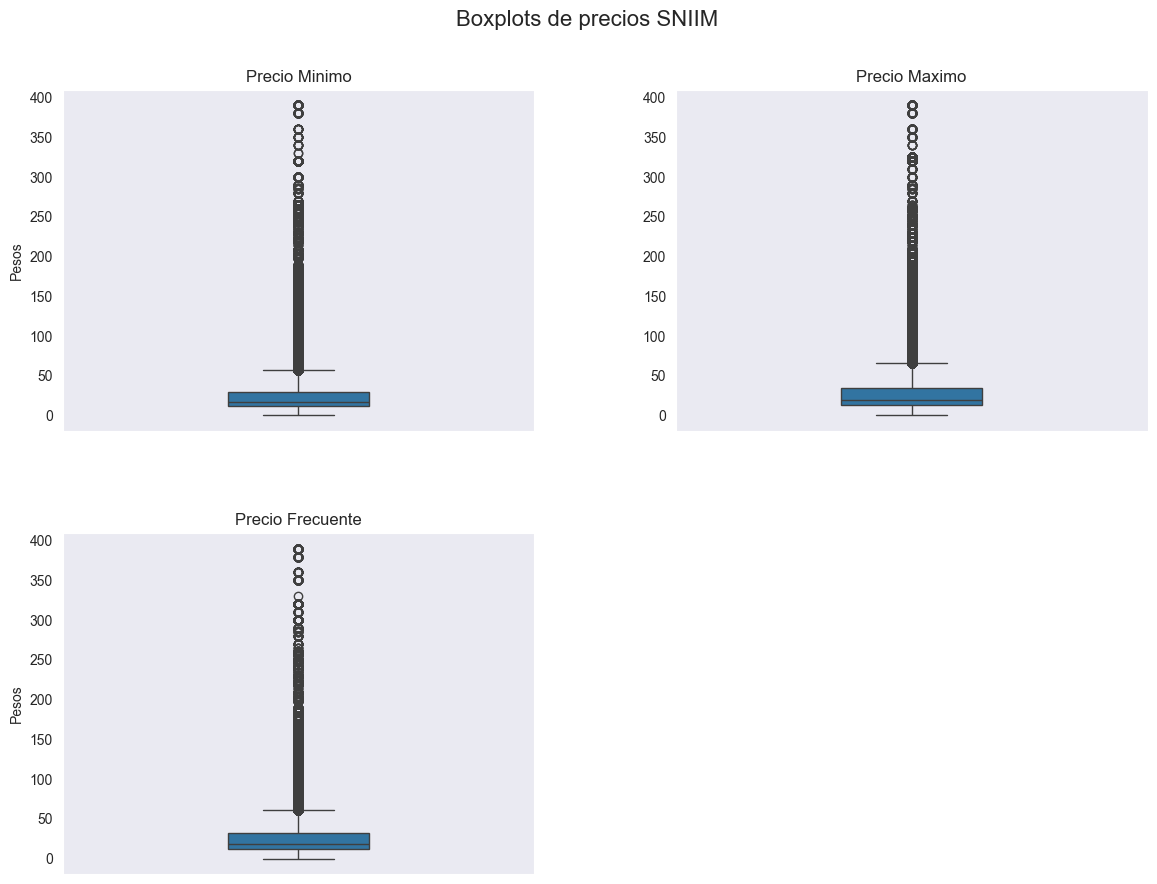

In [90]:
# Fijamos estilo
sns.set_style("dark")

# Configurar la figura y los subplots
num_rows = 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    sns.boxplot(data=df_sniim_orig_cult, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de precios SNIIM', fontsize=16)

axes[0].set_ylabel('Pesos')
axes[2].set_ylabel('Pesos')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

In [91]:
# # Configurar la figura y los subplots
# num_rows = 2
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# # Ajustar el espacio entre subplots
# fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# # Asegurarse de que 'axes' sea una matriz 2D
# axes = axes.reshape(-1)

# # Iterar a través de las columnas numéricas y crear histogramas de densidad kde
# for i, variable in enumerate(VARIABLES_NUMERICAS_MENSUALES):
#     sns.histplot(data=df_siap, x=variable, kde=True, ax=axes[i])
#     axes[i].set_title(f'{variable}')
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')

# # Eliminar la subgráfica vacía correspondiente a la variable FastingBS
# fig.delaxes(axes[-1])

# # Agregar un título general a la figura
# fig.suptitle('Distribuciones de densidad de variables mensuales SIAP', fontsize=16)

# axes[0].set_ylabel('Hectáreas')
# axes[3].set_ylabel('Toneladas')
# axes[4].set_ylabel('Tonelada / Hectárea')

# # Ajustar el espaciado entre subplots
# #plt.tight_layout()

# # Mostrar la figura
# plt.show()

#### Método Local Factor Outlier

In [92]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_sniim_orig_cult.drop(columns=['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_sniim_orig_cult) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 25717
Porcentaje con respecto al total de datos: 8.99%


Inspeccionamos algunos datos outlier según Local Factor Outlier

In [93]:
# Obtener datos outlier según LOF
outliers_LOF = df_sniim_orig_cult[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=10)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
41305,2020-08-25,Baja California,"Baja California : Central de Abasto INDIA, Tij...",Tomate rojo (jitomate),15.015000,15.015000,15.015000
45817,2020-09-14,Michoacán,DF: Central de Abasto de Iztapalapa DF,Limón,13.160000,18.155000,15.000000
161544,2022-04-06,Baja California,"Baja California : Central de Abasto INDIA, Tij...",Tomate rojo (jitomate),18.930000,18.930000,18.930000
155373,2022-03-08,Ciudad de México,México: Central de Abasto de Ecatepec,Mango,15.830000,17.860000,17.143333
254141,2023-06-09,Guerrero,México: Central de Abasto de Toluca,Mango,10.396667,11.263333,10.396667
13536,2020-02-21,Guanajuato,Guanajuato: Central de Abasto de León,Cebolla,11.670000,12.000000,11.670000
90220,2021-04-28,Chiapas,DF: Central de Abasto de Iztapalapa DF,Mango,6.790000,9.290000,7.860000
243433,2023-04-25,Puebla,"Tamaulipas: Módulo de Abasto de Tampico, Mader...",Papa,13.000000,13.330000,13.330000
19464,2020-03-20,Guerrero,México: Central de Abasto de Toluca,Melón,11.125000,12.915000,11.975000
247084,2023-05-12,Baja California,"Baja California : Central de Abasto INDIA, Tij...",Chile verde,14.720000,14.720000,14.720000


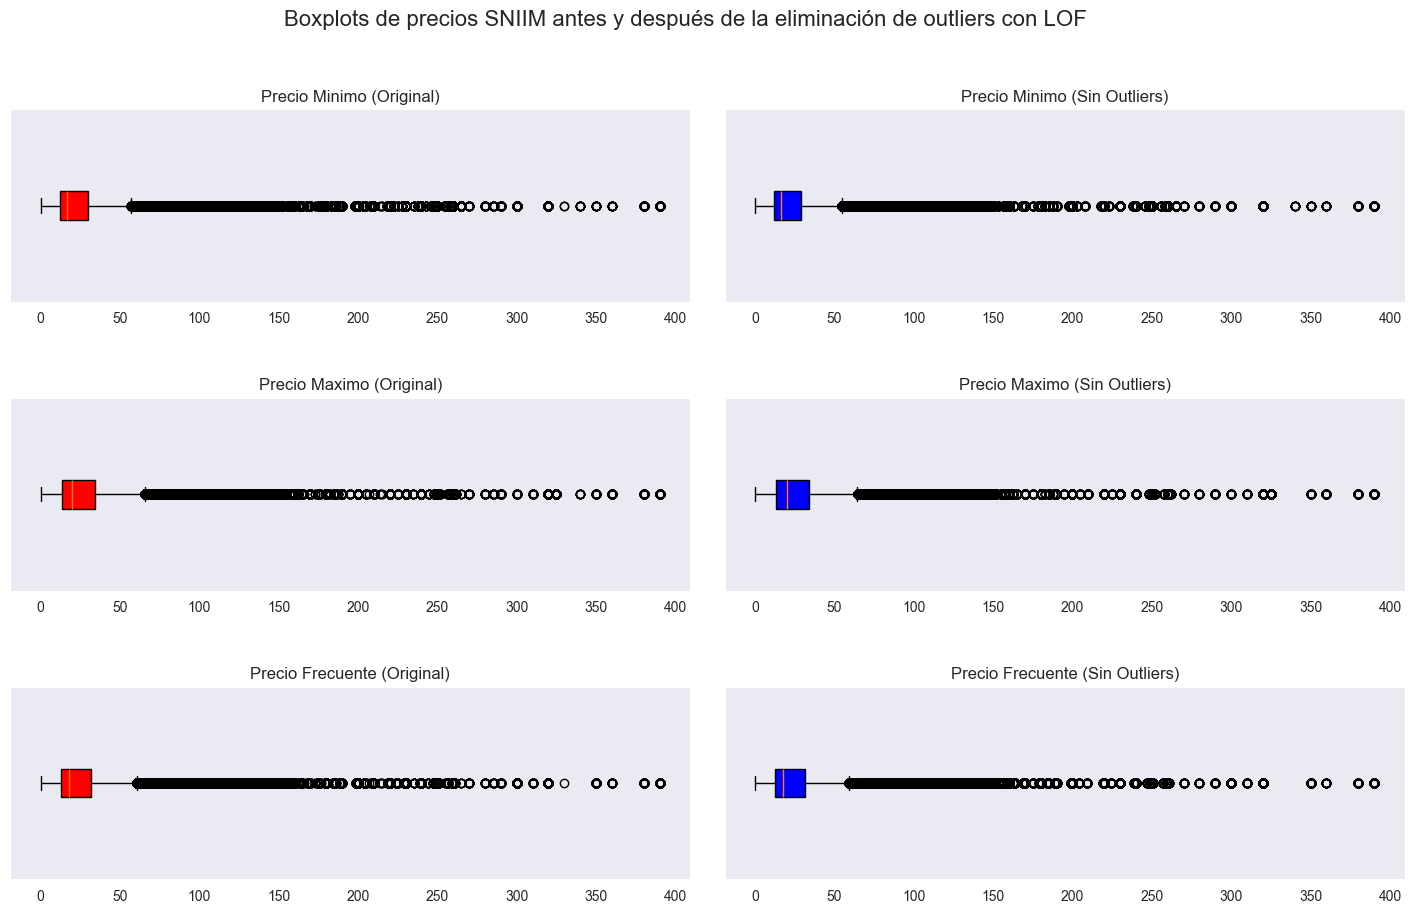

In [94]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_sniim_orig_cult[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_sniim_orig_cult[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de precios SNIIM antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=.5, wspace=0.05)

# Mostrar la figura
plt.show()

#### Método Isolation Forest

In [95]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas 
X = df_sniim_orig_cult.drop(columns=['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_sniim_orig_cult) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")

Cantidad de outliers: 48582
Porcentaje con respecto al total de datos: 16.98%


Inspeccionamos algunos datos outlier según Isolation Forest

In [96]:
# Obtener datos outlier según IF
outliers_IF = df_sniim_orig_cult[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=20)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
158324,2022-03-22,Nuevo León,Tamaulipas: Módulo de Abasto de Reynosa,Uva,65.000,78.000,68.000
283058,2023-10-11,Importación,"Baja California : Central de Abasto INDIA, Tij...",Pera,141.500,141.500,141.500
48829,2020-09-28,Chihuahua,Chihuahua: Mercado de Abasto de Cd. Juárez,Sandía,4.000,4.000,4.000
273288,2023-08-29,Ciudad de México,"Yucatán: Mercado ""Casa del Pueblo""",Uva,60.000,60.000,60.000
50276,2020-10-02,Importación,"Nuevo León: Mercado de Abasto ""Estrella"" de Sa...",Espárrago,150.000,150.000,150.000
87116,2021-04-14,Chihuahua,Chihuahua: Central de Abasto de Chihuahua,Nuez,230.000,230.000,230.000
156466,2022-03-11,Quintana Roo,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Fresa,90.000,90.000,90.000
89044,2021-04-22,Importación,DF: Central de Abasto de Iztapalapa DF,Uva,47.500,62.500,52.500
82697,2021-03-22,Sonora,Sonora: Central de Abasto de Cd. Obregón,Uva,71.000,71.000,71.000
256821,2023-06-21,Baja California Sur,Baja California Sur: Unión de Comerciantes de ...,Chile verde,10.000,50.000,50.000


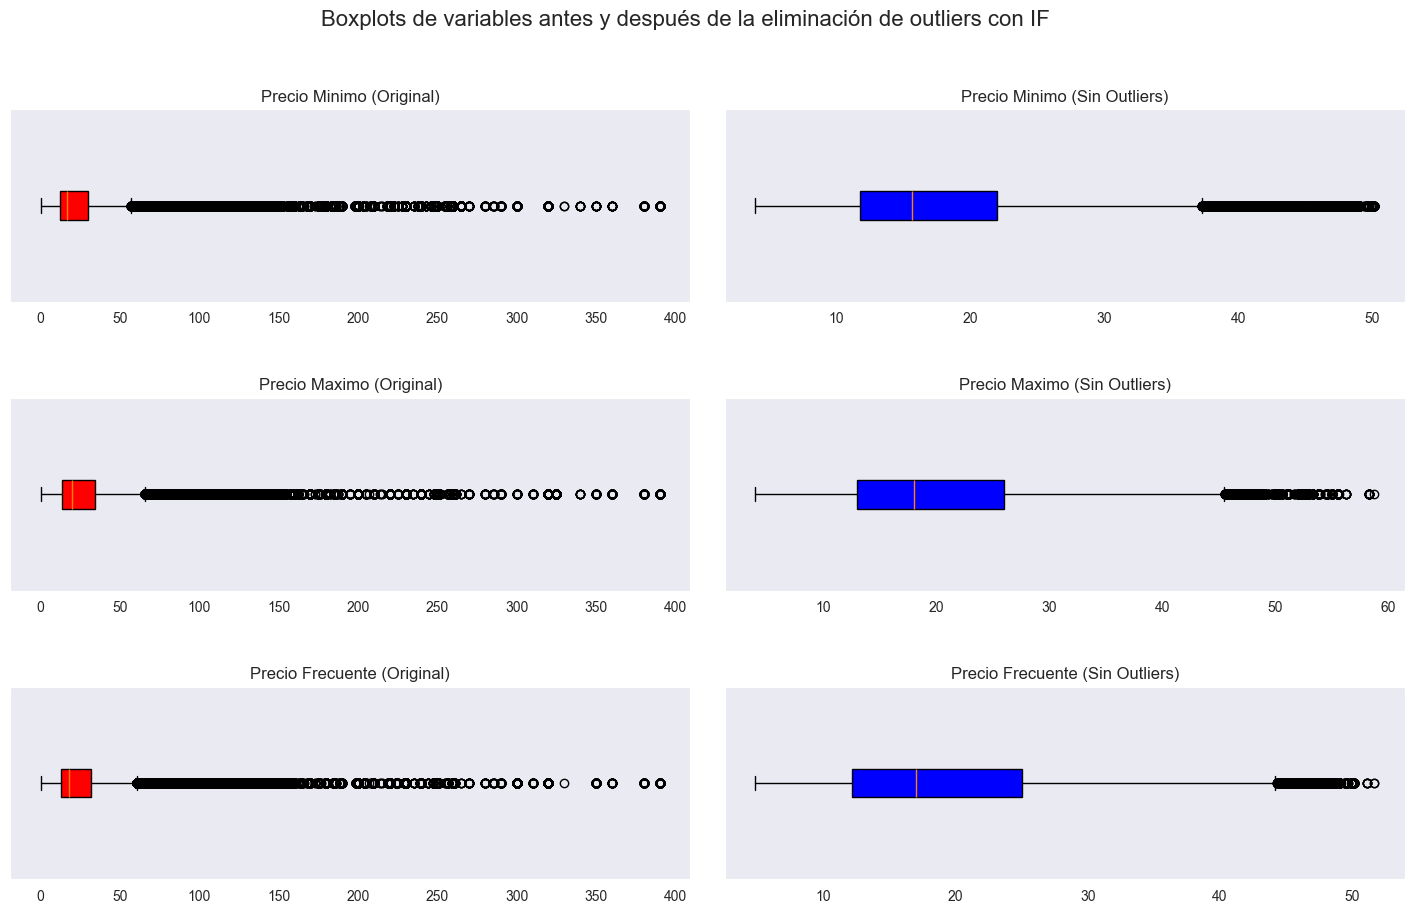

In [97]:
# Eliminar outliers del DataFrame
df_clean_IF = df_sniim_orig_cult[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_sniim_orig_cult[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=0.5, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los outliers putativos no nos permite identificarlos como verdaderamente valores atípicos. Es normal que ciertos cultivos, como la nuez, se mantengan con precios muy por encima de otros cultivos.

In [98]:
# # Realizar el merge
# df_merge = pd.merge(
#     df_siap_diff,
#     df_sniim_dest_orig_cult_mens,
#     how='inner',
#     left_on=['Año', 'Mes', 'Entidad', 'Cultivo'],
#     right_on=['Año', 'Mes', 'Origen', 'Cultivo SIAP']
# )

# # Eliminar las columnas duplicadas (puedes ajustar según tus necesidades)
# df_merge = df_merge.drop(['Origen', 'Cultivo SIAP'], axis=1)

# # Mostrar el DataFrame resultante
# df_merge

## Relaciones entre variables por visualización

In [99]:
# Magic command para hacer gráficas interactivas
#%matplotlib widget

### Análisis temporal: ¿En qué épocas del año es más probable que se generen excedentes? 

Analizamos la evolución de las variables númericas a lo largo de los años, para cada uno de los cultivos de interés. Para esto, vamos a ignorar la información geográfica, promediando los valores a lo largo de todos los municipios y estados. Hacemos esto para las variables mensuales y acumuladas del SIAP por un lado, y para los precios del SNIIM por el otro.

In [100]:
#SIAP mensual

# Promediamos por año, mes y cultivo
df_siap_año_mes_cult = df_siap.groupby(['Año', 'Mes', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[:5]].mean().reset_index()

#SIAP acumulado

# Promediamos por año, mes y cultivo
df_siap_año_mes_cult_cum = df_siap.groupby(['Año', 'Mes', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[5:]].mean().reset_index()

# SNIIM mensual

df_sniim_año_mes_cult = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Cultivo SIAP'])[VARIABLES_NUMERICAS_SNIIM].mean().reset_index()

In [102]:
# Función para obtener la etiqueta del eje y según el tipo de variable
def get_label(variable):
    if variable in ['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada']:
        return 'Hectáreas'
    elif variable in ['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']:
        return 'Pesos'
    elif variable == 'Produccion':
        return 'Toneladas'
    elif variable == 'Rendimiento':
        return 'Tonelada/Hectárea'
    else:
        return ''

In [179]:
# Fijamos estilo
sns.set_style("white")

# Función para actualizar el gráfico según el cultivo y variable seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Seleccionar el DataFrame correspondiente según la variable
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_año_mes_cult
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_año_mes_cult
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar la producción promedio de todos los cultivos
        sns.barplot(x='Mes', y=variable, hue='Año', data=data, palette=COLORES, ci=False, estimator='mean')
        title = f'{variable} promedio de Todos los Cultivos por mes y año'
    else:
        # Seleccionar el DataFrame correspondiente según la variable y cultivo
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_año_mes_cult[df_siap_año_mes_cult['Cultivo'] == cultivo]
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_año_mes_cult[df_sniim_año_mes_cult['Cultivo SIAP'] == cultivo]
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar la producción del cultivo seleccionado
        sns.barplot(x='Mes', y=variable, hue='Año', data=data, palette=COLORES, ci=False)
        title = f'{variable} de {cultivo} por mes y año'

    # Añadir título y etiquetas a los ejes
    plt.title(title)
    plt.xlabel('Mes')

    # Añadir label y dinámico al eje y
    plt.ylabel(get_label(variable))

    # Mostrar la leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

# Añadir la opción "Todos los cultivos" a la lista de cultivos
cultivos_unicos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Para facilitar el análisis comparativo entre los distintos años, repetimos la gráfica pero ahora de manera acumulada. Esto no solo facilita comparar los patrones de evolución a lo largo de cada año, sino que permite comparar los valores totales de cada año simplemente inspeccionando el mes de Diciembre. 

In [180]:
# Fijamos estilo
sns.set_style("white")

# Función para actualizar el gráfico según el cultivo y variable seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Graficar la producción promedio de todos los cultivos
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_siap_año_mes_cult_cum, palette=COLORES, ci=False, estimator='mean')
        title = f'{variable} Promedio de Todos los Cultivos por mes y año'
    else:
        # Graficar la producción del cultivo seleccionado
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_siap_año_mes_cult_cum[df_siap_año_mes_cult_cum['Cultivo'] == cultivo], palette=COLORES, ci=False)
        title = f'{variable} de {cultivo} por mes y año'

    # Añadir título y etiquetas a los ejes
    plt.title(title)
    plt.xlabel('Mes')

    # Añadir label y dinámico al eje y
    plt.ylabel(get_label(variable))

    # Mostrar la leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[5:], value='Produccion Acumulada', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Habiendo analizado el patrón de evolución a lo largo de los meses de los distintos años, procedemos a identificar cuáles son, en promedio, los meses con mejores métricas.

In [181]:
# Promediar los valores entre todos los años
df_siap_promedio_anual = df_siap_año_mes_cult.groupby('Mes')[VARIABLES_NUMERICAS_SIAP[:5]].mean().reset_index()
df_sniim_promedio_anual = df_sniim_año_mes_cult.groupby('Mes')[VARIABLES_NUMERICAS_SNIIM].mean().reset_index()

# Función para actualizar el gráfico de barras horizontales según la variable y el cultivo seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Seleccionar el DataFrame correspondiente según la variable
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_promedio_anual
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_promedio_anual
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar barras horizontales para el promedio de todos los cultivos
        order = data.groupby('Mes')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Mes', data=data, ci=False, palette=color_palette, order=order)
        title = f'Promedio anual de {variable} para todos los cultivos por mes'
    else:
        # Seleccionar el DataFrame correspondiente según la variable y cultivo
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_año_mes_cult[df_siap_año_mes_cult['Cultivo'] == cultivo]
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_año_mes_cult[(df_sniim_año_mes_cult['Cultivo SIAP'] == cultivo)]
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
        order = data.groupby('Mes')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Mes', data=data, ci=False, palette=color_palette, order=order)
        title = f'Promedio anual de {variable} para {cultivo} por mes'

    # Añadir título y etiquetas a los ejes
    plt.title(title, pad=20)
    plt.xlabel(f'{variable} Promedio Anual')
    plt.ylabel('Mes')

    # Añadir label x dinámico
    plt.xlabel(get_label(variable))

    # Eliminar bordes
    plt.gca().spines['left'].set_visible(False)  # Izquierdo
    plt.gca().spines['top'].set_visible(False)   # Superior
    plt.gca().spines['right'].set_visible(False) # Derecho
    plt.gca().spines['bottom'].set_visible(False) # Inferior

    # Eliminar xticks
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Añadir valores en la parte superior de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.show()

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
#cultivo_sniim_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo SNIIM')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Procedemos a analizar la evolución de las distintas variables numéricas pero ahora a lo largo de todo el periodo del que se tienen datos. Prestamos especial interés a los meses identificados con mejores y peores métricas.

In [177]:
# Función para graficar
def plot_graph(cultivo, variable):
    plt.subplots(1, 1, figsize=(12, 8))
    
    if cultivo == 'Todos los cultivos':
        # Grafica el promedio de la variable para todos los cultivos
        if variable in VARIABLES_NUMERICAS_SIAP:
            df_all_cultivos_var = df_siap_filtered.groupby('Fecha')[variable].mean().reset_index()
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            df_all_cultivos_var = df_sniim_filtered.groupby('Fecha')[variable].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable} no es válida.")
            
        # Asignar colores según la lista COLORES
        unique_years = df_all_cultivos_var['Fecha'].dt.year.unique()
        color_palette = COLORES[:len(unique_years)]
        
        for i, year in enumerate(unique_years):
            df_year = df_all_cultivos_var[df_all_cultivos_var['Fecha'].dt.year.isin((year, year+1))]
            plt.plot(df_year['Fecha'], df_year[variable], marker='o', linestyle='-', color=color_palette[i], label=f'{year}')

        # Añadir título
        plt.title(f'{variable} de todos los cultivos', pad=30, fontsize=16, fontweight='bold', va='center')

    else:
        # Filtra por el cultivo seleccionado y utiliza el DataFrame correspondiente
        if variable in VARIABLES_NUMERICAS_SIAP:
            df_cultivo = df_siap_filtered[df_siap_filtered['Cultivo'] == cultivo]
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            df_cultivo = df_sniim_filtered[df_sniim_filtered['Cultivo SIAP'] == cultivo]
        else:
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Asignar colores según la lista COLORES
        unique_years = df_cultivo['Fecha'].dt.year.unique()
        color_palette = COLORES[:len(unique_years)]
        
        for i, year in enumerate(unique_years):
            df_year = df_cultivo[df_cultivo['Fecha'].dt.year.isin((year, year+1))]
            plt.plot(df_year['Fecha'], df_year[variable], marker='o', linestyle='-', color=color_palette[i], label=f'{year}')
        
        # Añadir título
        plt.title(f'{variable} de {cultivo}', pad=30)

    # Etiquetas para el eje y
    plt.ylabel(get_label(variable), labelpad=20)

    plt.xlabel('Fecha', labelpad=20)
    plt.tight_layout()
    
    # Fijar el rango del eje x
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
    
    # Añadir leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Crea los widgets interactivos
interact(plot_graph, 
         cultivo=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
         variable=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Superficie Sembrada', description='Variable'))


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_graph(cultivo, variable)>

Podemos inspeccionar simultaneamente la evolución de las distintas parejas de variables numéricas en busca de alguna relación significativa.

In [176]:
# Función para graficar
def plot_graph(cultivo, variable1, variable2):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))
    
    if cultivo == 'Todos los cultivos':
        # Grafica el promedio de la variable1 para todos los cultivos
        if variable1 in VARIABLES_NUMERICAS_SIAP:
            df_all_cultivos_var1 = df_siap_filtered.groupby(['Fecha'])[variable1].mean().reset_index()
        elif variable1 in VARIABLES_NUMERICAS_SNIIM:
            df_all_cultivos_var1 = df_sniim_filtered.groupby(['Fecha'])[variable1].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable1} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_all_cultivos_var1['Fecha'].dt.year.unique()):
            df_year = df_all_cultivos_var1[df_all_cultivos_var1['Fecha'].dt.year.isin((year, year + 1))]
            axs[0].plot(df_year['Fecha'], df_year[variable1], marker='o', linestyle='-', color=COLORES[i], label=f'{year}')

        axs[0].legend(loc='upper right')
        axs[0].set_xticks([])  # Elimina las marcas del eje x
        
        # Grafica el promedio de la variable2 para todos los cultivos
        if variable2 in VARIABLES_NUMERICAS_SIAP:
            df_all_cultivos_var2 = df_siap_filtered.groupby(['Fecha'])[variable2].mean().reset_index()
        elif variable2 in VARIABLES_NUMERICAS_SNIIM:
            df_all_cultivos_var2 = df_sniim_filtered.groupby(['Fecha'])[variable2].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable2} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_all_cultivos_var2['Fecha'].dt.year.unique()):
            df_year = df_all_cultivos_var2[df_all_cultivos_var2['Fecha'].dt.year.isin((year, year + 1))]
            axs[1].plot(df_year['Fecha'], df_year[variable2], marker='o', linestyle='-', color=COLORES[i], label='_')

        axs[1].legend(loc='upper right')
        
        # Calcular la correlación
        corr_value = df_all_cultivos_var1[variable1].corr(df_all_cultivos_var2[variable2])
        # Añadir el valor de correlación como texto en la figura
        fig.text(1.07, 0.505, f'Corr: {corr_value:.2f}', ha='center', va='center', fontsize=18, fontweight='bold')

        # Añadir título superior
        suptitle = f'{variable1} vs {variable2} de {cultivo}'
        suptitle_obj = fig.suptitle(suptitle, fontsize=16, fontweight='bold', va='center')
        # Ajustar la posición vertical del título superior
        suptitle_obj.set_y(1)

    else:
        # Filtra por el cultivo seleccionado
        if variable1 in VARIABLES_NUMERICAS_SIAP:
            df_cultivo_var1 = df_siap_filtered[df_siap_filtered['Cultivo'] == cultivo].groupby(['Fecha'])[variable1].mean().reset_index()
        elif variable1 in VARIABLES_NUMERICAS_SNIIM:
            df_cultivo_var1 = df_sniim_filtered[df_sniim_filtered['Cultivo SIAP'] == cultivo].groupby(['Fecha'])[variable1].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable1} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_cultivo_var1['Fecha'].dt.year.unique()):
            df_year = df_cultivo_var1[df_cultivo_var1['Fecha'].dt.year.isin((year, year + 1))]
            axs[0].plot(df_year['Fecha'], df_year[variable1], marker='o', linestyle='-', color=COLORES[i], label=f'{year}')

        axs[0].legend(loc='upper right')
        axs[0].set_xticks([])  # Elimina las marcas del eje x
        
        # Filtra por el cultivo seleccionado
        if variable2 in VARIABLES_NUMERICAS_SIAP:
            df_cultivo_var2 = df_siap_filtered[df_siap_filtered['Cultivo'] == cultivo].groupby(['Fecha'])[variable2].mean().reset_index()
        elif variable2 in VARIABLES_NUMERICAS_SNIIM:
            df_cultivo_var2 = df_sniim_filtered[df_sniim_filtered['Cultivo SIAP'] == cultivo].groupby(['Fecha'])[variable2].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable2} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_cultivo_var2['Fecha'].dt.year.unique()):
            df_year = df_cultivo_var2[df_cultivo_var2['Fecha'].dt.year.isin((year, year + 1))]
            axs[1].plot(df_year['Fecha'], df_year[variable2], marker='o', linestyle='-', color=COLORES[i], label='_')
        
        axs[1].legend(loc='upper right')

        # Calcular la correlación
        corr_value = df_cultivo_var1[variable1].corr(df_cultivo_var2[variable2])
        # Añadir el valor de correlación como texto en la figura
        fig.text(1.07, 0.515, f'Corr: {corr_value:.2f}', ha='center', va='center', fontsize=14, fontweight='bold')

        # Añadir título superior
        suptitle = f'{variable1} vs {variable2} de {cultivo}'
        suptitle_obj = fig.suptitle(suptitle, fontsize=16, fontweight='bold', va='center')
        # Ajustar la posición vertical del título superior
        suptitle_obj.set_y(1)

    # Etiquetas para el eje y
    axs[0].set_ylabel(get_label(variable1))
    axs[1].set_ylabel(get_label(variable2))

    plt.xlabel('Fecha')
    plt.tight_layout()
    
    # Fijar el rango del eje x
    plt.xlim(df_siap_filtered['Fecha'].min(), df_siap_filtered['Fecha'].max())
        
    plt.show()

# Crea los widgets interactivos
interact(plot_graph, 
         cultivo=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
         variable1=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Superficie Sembrada', description='Variable 1'),
         variable2=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Superficie Cosechada', description='Variable 2'))


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_graph(cultivo, variable1, variable2)>

### Análisis geográfico: ¿En qué ubicaciones es más probable que se generen excedentes? 

In [54]:
import geopandas
geo_df = geopandas.read_file("https://gist.githubusercontent.com/walkerke/76cb8cc5f949432f9555/raw/363c297ce82a4dcb9bdf003d82aa4f64bc695cf1/mx.geojson")
geo_df.head()

,id,name,state,mus09,pri10,sec10,ter10,gdp08,other10,geometry
0,1,Aguascalientes,Aguascalientes,17.1,6.34,28.74,64.28,84.70,0.64,"MULTIPOLYGON (((-102.21140 22.35450, -102.1908..."
1,2,Baja California,Baja California,15.4,5.44,31.64,61.68,83.07,1.24,"MULTIPOLYGON (((-114.09429 28.02418, -114.0774..."
2,3,Baja California Sur,Baja California Sur,3.0,9.18,17.48,72.37,94.64,0.97,"MULTIPOLYGON (((-109.79843 24.15516, -109.8028..."
3,4,Campeche,Campeche,7.0,19.24,21.20,57.11,395.55,2.45,"MULTIPOLYGON (((-91.52440 18.76659, -91.52457 ..."
4,5,Chiapas,Chiapas,13.9,42.76,13.51,42.90,34.44,0.83,"MULTIPOLYGON (((-93.97061 16.00979, -93.96390 ..."


<Axes: >

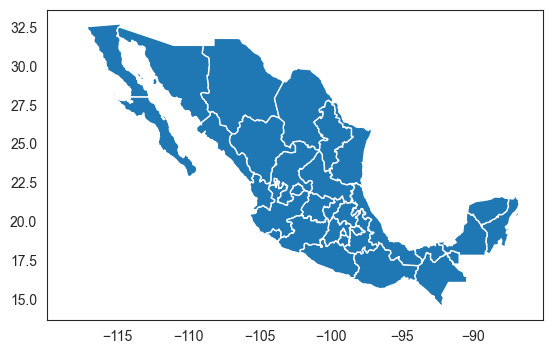

In [55]:
geo_df.plot()

## Correlación entre variables

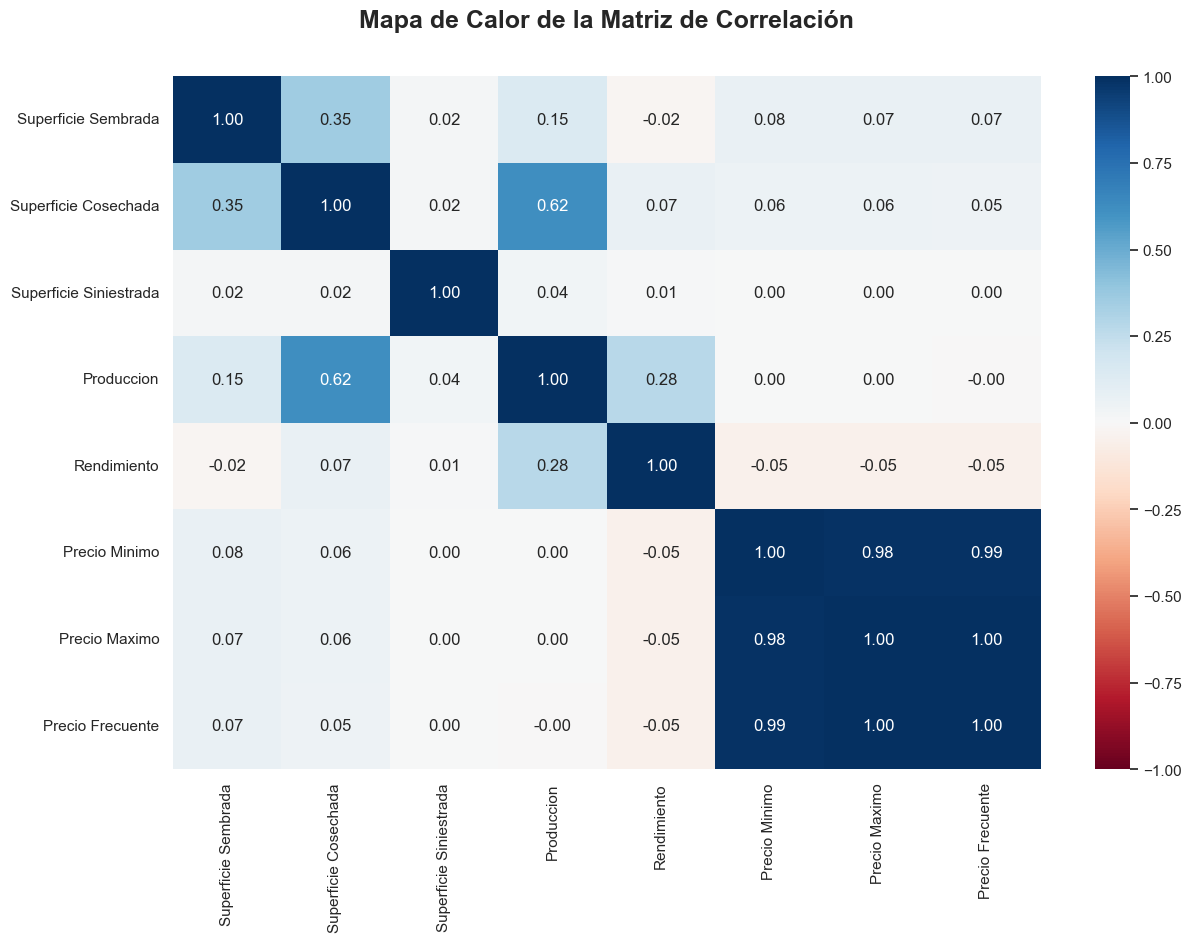

In [65]:
# Calcula la matriz de correlación
correlation_matrix = df_merge[VARIABLES_NUMERICAS].corr()

# Fijar estilo
sns.set(style="white")

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize = (14,9))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de Calor de la Matriz de Correlación', pad=40, ha='center', va='center', fontsize=18, fontweight='bold')
# Rotar los labels del eje x a 90 grados
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

#Mostrar gráfica
plt.show()
     